# Regression

## 1. Do an exploratory data analysis on the mpg dataset from seaborn.

# MPG Dataset Description

| **Column**      | **Type**       | **Description**                                | **Unit/Values**                        |
|------------------|----------------|-----------------------------------------------|----------------------------------------|
| **mpg**         | Continuous     | Miles per gallon, representing fuel efficiency | Miles per gallon                       |
| **cylinders**   | Categorical    | Number of cylinders in the engine             | Typical values: 4, 6, 8               |
| **displacement**| Continuous     | Engine displacement (size of the engine)      | Cubic inches                           |
| **horsepower**  | Continuous     | Power of the car’s engine                     | Horsepower (HP)                        |
| **weight**      | Continuous     | Weight of the car                             | Pounds                                 |
| **acceleration**| Continuous     | Time it takes to accelerate from 0 to 60 mph  | Seconds                                |
| **model_year**  | Categorical    | Year the car model was manufactured           | 1970–1982                              |
| **origin**      | Categorical    | Country of origin of the car                  | `usa`, `europe`, `japan`               |
| **name**        | Categorical    | Name and details of the car (make and model)  | Text                                   |


In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import warnings

from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

warnings.filterwarnings('ignore')

In [2]:
mpg_data = sns.load_dataset('mpg')
mpg_data.sample(10)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
87,13.0,8,350.0,145.0,3988,13.0,73,usa,chevrolet malibu
191,22.0,6,225.0,100.0,3233,15.4,76,usa,plymouth valiant
378,38.0,4,105.0,63.0,2125,14.7,82,usa,plymouth horizon miser
297,25.4,5,183.0,77.0,3530,20.1,79,europe,mercedes benz 300d
145,32.0,4,83.0,61.0,2003,19.0,74,japan,datsun 710
108,20.0,4,97.0,88.0,2279,19.0,73,japan,toyota carina
391,36.0,4,135.0,84.0,2370,13.0,82,usa,dodge charger 2.2
43,13.0,8,400.0,170.0,4746,12.0,71,usa,ford country squire (sw)
206,26.5,4,140.0,72.0,2565,13.6,76,usa,ford pinto
352,29.9,4,98.0,65.0,2380,20.7,81,usa,ford escort 2h


In [3]:
mpg_data.shape

(398, 9)

In [4]:
mpg_data.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
name            0
dtype: int64

In [5]:
mpg_data.dropna(inplace=True)

In [6]:
mpg_data.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight            int64
acceleration    float64
model_year        int64
origin           object
name             object
dtype: object

In [7]:
# Compute the correlation matrix of numerical columns
corr_matrix = mpg_data.select_dtypes(include='number').corr()

# Visualize the correlation matrix with a background gradient
corr_matrix.style.background_gradient(cmap='viridis')

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year
mpg,1.000000,-0.777618,-0.805127,-0.778427,-0.832244,0.423329,0.580541
cylinders,-0.777618,1.000000,0.950823,0.842983,0.897527,-0.504683,-0.345647
displacement,-0.805127,0.950823,1.000000,0.897257,0.932994,-0.543800,-0.369855
horsepower,-0.778427,0.842983,0.897257,1.000000,0.864538,-0.689196,-0.416361
weight,-0.832244,0.897527,0.932994,0.864538,1.000000,-0.416839,-0.309120
acceleration,0.423329,-0.504683,-0.543800,-0.689196,-0.416839,1.000000,0.290316
model_year,0.580541,-0.345647,-0.369855,-0.416361,-0.309120,0.290316,1.000000


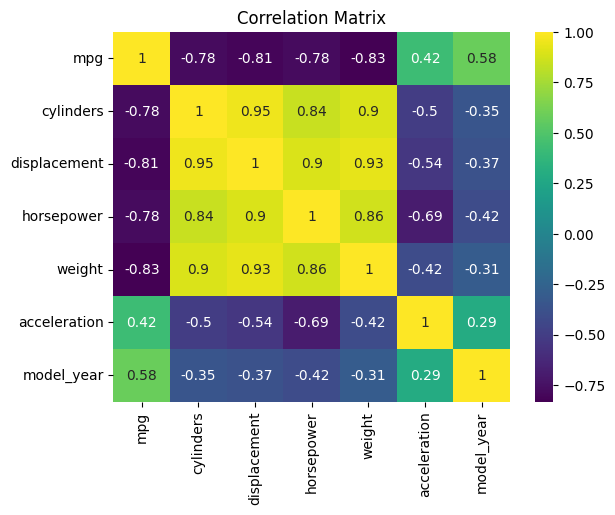

In [8]:
sns.heatmap(corr_matrix, annot=True, cmap='viridis')
plt.title('Correlation Matrix')
plt.show()

* `displacement` is highly correlated with `horsepower` and `weight`
    * big machine normally has high horsepower and heavy weight
* `horsepower` is highly correlated with `weight`
    * heavyweight cars need strong horsepower
* `cylinders` is highly correlated with `displacement`, `horsepower`, and `weight`
    * large displacement, strong horsepower, heavyweight cars normally contain more cylinders.

In [9]:
origin_count = mpg_data['origin'].value_counts()
origin_count

origin
usa       245
japan      79
europe     68
Name: count, dtype: int64

In [10]:
print(f"There are {mpg_data['name'].nunique()} unique cars, {origin_count[0]} from USA, {origin_count[1]} from Japan, and {origin_count[2]} from Europe.")

There are 301 unique cars, 245 from USA, 79 from Japan, and 68 from Europe.


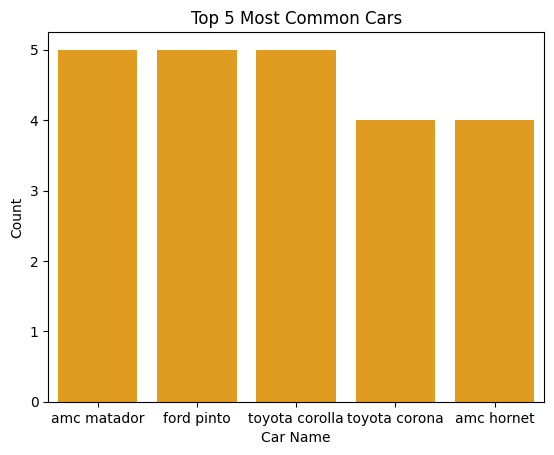

In [11]:
sns.barplot(mpg_data['name'].value_counts().nlargest(5), color='orange')

plt.title('Top 5 Most Common Cars')
plt.xlabel('Car Name')
plt.ylabel('Count')
plt.show()

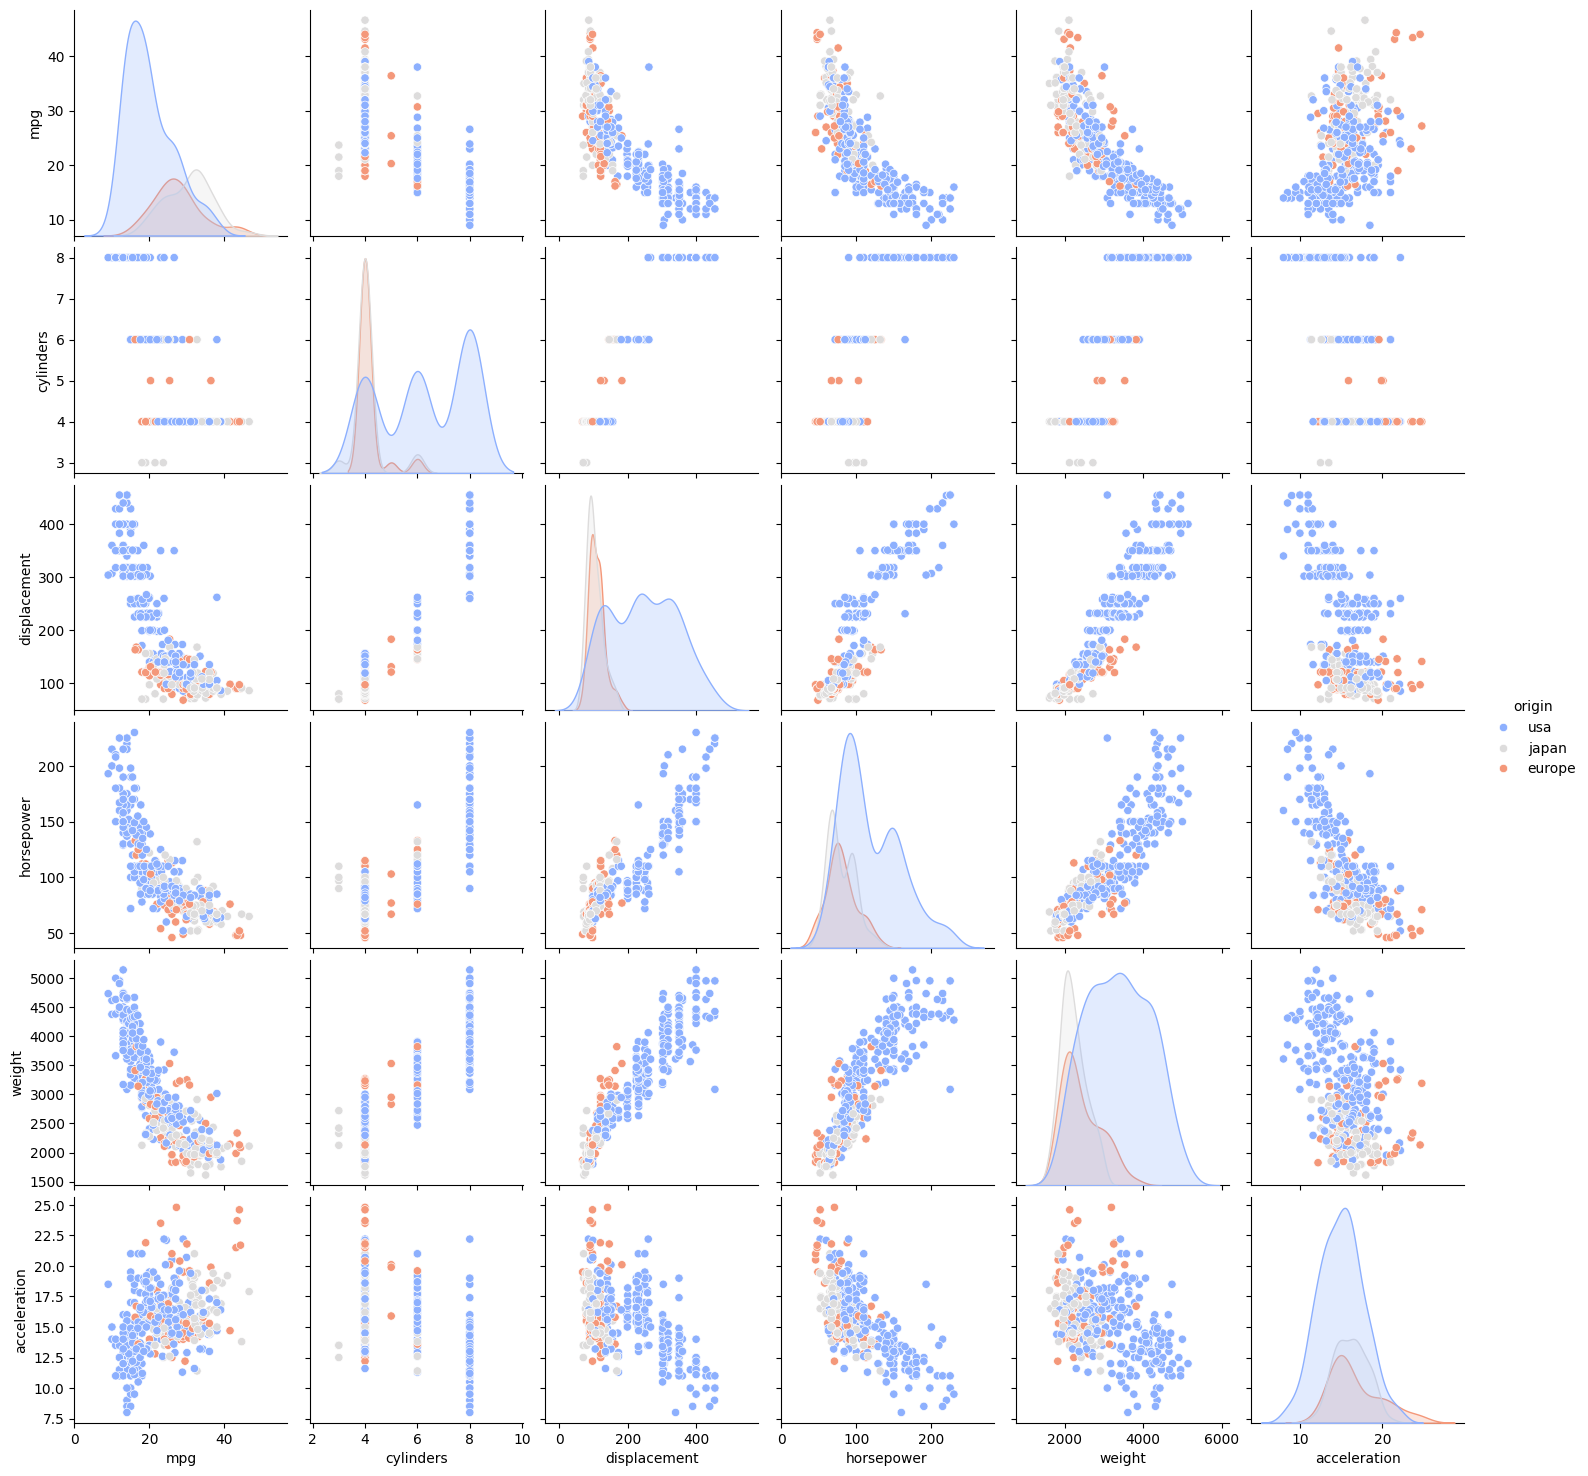

In [12]:
num_vars = mpg_data.select_dtypes(include='number').drop(columns='model_year')
obj_vars = mpg_data.select_dtypes(include='object')

sns.pairplot(data=num_vars.join(mpg_data['origin']), hue='origin', palette='coolwarm');

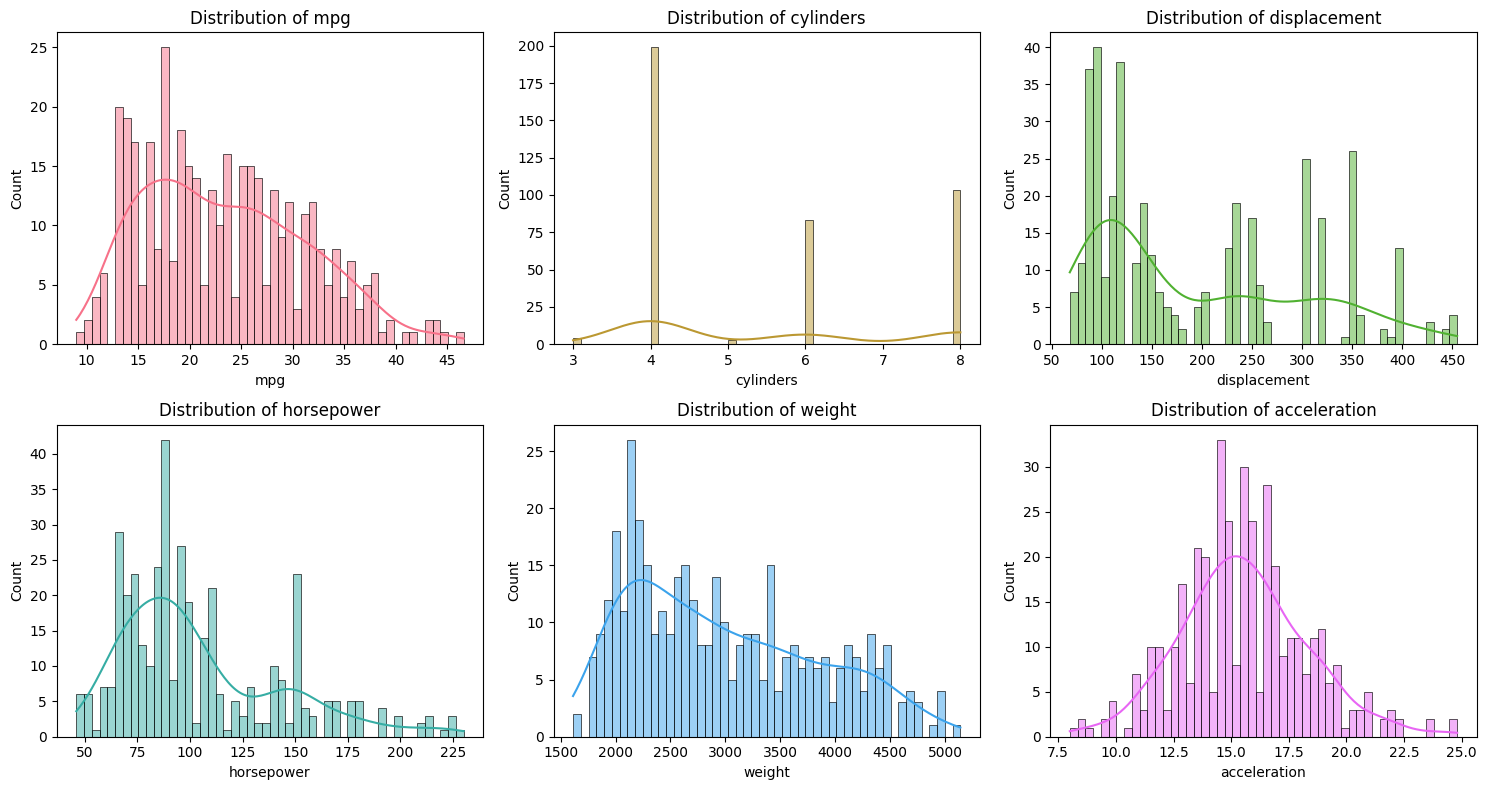

In [13]:
colors = sns.color_palette("husl", len(num_vars.columns))
fig, ax = plt.subplots(2, 3, figsize=(15, 8))
ax = ax.flatten()  # Flatten the array of axes
i = 0
for var, color in zip(num_vars.columns, colors):
    sns.histplot(num_vars, x=var, kde=True, ax=ax[i], bins=50, color=color)
    ax[i].set_title(f"Distribution of {var}")
    i += 1
plt.tight_layout()

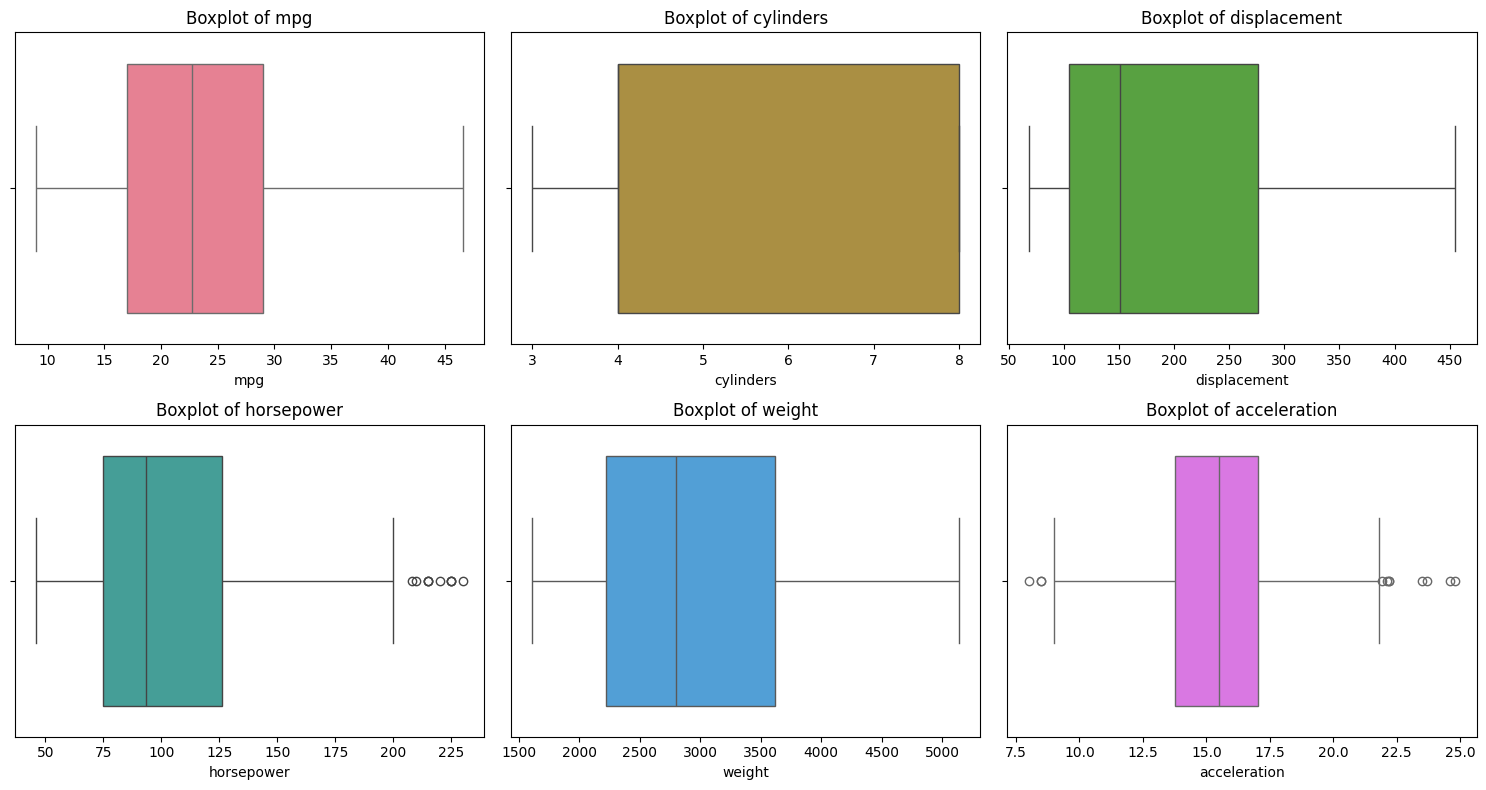

In [14]:
colors = sns.color_palette("husl", len(num_vars.columns))
fig, ax = plt.subplots(2, 3, figsize=(15, 8))
ax = ax.flatten()  # Flatten the array of axes
i = 0
for var, color in zip(num_vars.columns, colors):
    sns.boxplot(num_vars, x=var, ax=ax[i], color=color)
    ax[i].set_title(f"Boxplot of {var}")
    i += 1
plt.tight_layout()

## 2. First use scikit-learn and next use PyTorch to build binary logistic regression and do all the neccessary things in machine learning process.
* Target: `mpg`
* Features: Use appropriate tools and reasoning to choose the important features for the model

Correlation with Target (mpg):
 mpg             1.000000
cylinders      -0.777618
displacement   -0.805127
horsepower     -0.778427
weight         -0.832244
acceleration    0.423329
model_year      0.580541
Name: mpg, dtype: float64


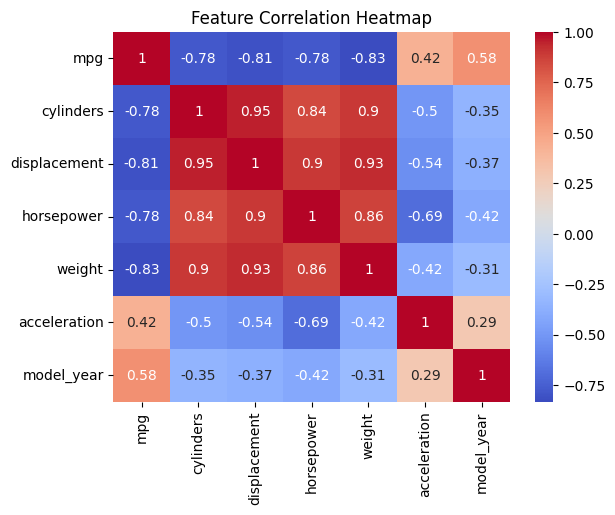

Feature Importance (Mutual Information):
weight          0.790390
displacement    0.788337
horsepower      0.736796
cylinders       0.602792
model_year      0.349894
acceleration    0.183165
dtype: float64


In [15]:
from sklearn.feature_selection import mutual_info_regression

# Encode categorical features for correlation analysis
mpg_data['origin'] = mpg_data['origin'].map({'usa': 0, 'europe': 1, 'japan': 2})

# Drop the 'name' column as it contains string values
mpg_data.drop(columns=['name', 'origin'], inplace=True)

# Correlation matrix
corr_matrix = mpg_data.corr()
print("Correlation with Target (mpg):\n", corr_matrix['mpg'])

# Visualize correlations
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

# Use mutual information for feature importance
X = mpg_data[['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year']]
y = mpg_data['mpg']
mutual_info = mutual_info_regression(X, y, random_state=42)

feature_importance = pd.Series(mutual_info, index=X.columns).sort_values(ascending=False)
print(f"Feature Importance (Mutual Information):\n{feature_importance}")


### Sklearn Logistic Regression

In [16]:
# Create a new binary feature for fuel efficiency
mpg_data['fuel_efficiency'] = mpg_data['mpg'].apply(lambda x: 0 if x < 20 else 1)
display(mpg_data.head())

# Define the target variable and features
X = mpg_data[['cylinders', 'displacement', 'horsepower', 'weight']]
y = mpg_data['fuel_efficiency']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a logistic regression model using scikit-learn
sk_model = LogisticRegression()
sk_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_sk = sk_model.predict(X_test_scaled)

# Evaluate the model
print("Scikit-learn Logistic Regression Results:")
print(confusion_matrix(y_test, y_pred_sk))
print(classification_report(y_test, y_pred_sk))

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,fuel_efficiency
0,18.0,8,307.0,130.0,3504,12.0,70,0
1,15.0,8,350.0,165.0,3693,11.5,70,0
2,18.0,8,318.0,150.0,3436,11.0,70,0
3,16.0,8,304.0,150.0,3433,12.0,70,0
4,17.0,8,302.0,140.0,3449,10.5,70,0


Scikit-learn Logistic Regression Results:
[[26  3]
 [ 1 49]]
              precision    recall  f1-score   support

           0       0.96      0.90      0.93        29
           1       0.94      0.98      0.96        50

    accuracy                           0.95        79
   macro avg       0.95      0.94      0.94        79
weighted avg       0.95      0.95      0.95        79



<Axes: ylabel='Frequency'>

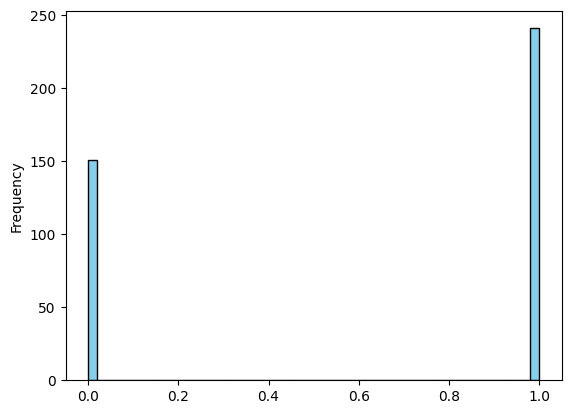

In [17]:
y.plot(kind='hist', bins=50, color='skyblue', edgecolor='black')

In [18]:
# ---- Logistic Regression with PyTorch ----
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Define the model
class MPGLogisticRegressionModel(nn.Module):
    def __init__(self):
        super(MPGLogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(4, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

# Initialize model, loss, and optimizer
# input_dim = X_train.shape[1]
model = MPGLogisticRegressionModel()
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training the model
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
y_pred_probs = model(X_test_tensor).detach().numpy()
y_pred_pt = (y_pred_probs >= 0.5).astype(int)

print("PyTorch Logistic Regression Results:")
print(confusion_matrix(y_test, y_pred_pt))
print(classification_report(y_test, y_pred_pt))


Epoch [10/1000], Loss: 0.9900
Epoch [20/1000], Loss: 0.8875
Epoch [30/1000], Loss: 0.7994
Epoch [40/1000], Loss: 0.7246
Epoch [50/1000], Loss: 0.6616
Epoch [60/1000], Loss: 0.6088
Epoch [70/1000], Loss: 0.5647
Epoch [80/1000], Loss: 0.5277
Epoch [90/1000], Loss: 0.4966
Epoch [100/1000], Loss: 0.4703
Epoch [110/1000], Loss: 0.4479
Epoch [120/1000], Loss: 0.4287
Epoch [130/1000], Loss: 0.4121
Epoch [140/1000], Loss: 0.3977
Epoch [150/1000], Loss: 0.3851
Epoch [160/1000], Loss: 0.3740
Epoch [170/1000], Loss: 0.3642
Epoch [180/1000], Loss: 0.3555
Epoch [190/1000], Loss: 0.3476
Epoch [200/1000], Loss: 0.3406
Epoch [210/1000], Loss: 0.3342
Epoch [220/1000], Loss: 0.3285
Epoch [230/1000], Loss: 0.3232
Epoch [240/1000], Loss: 0.3184
Epoch [250/1000], Loss: 0.3140
Epoch [260/1000], Loss: 0.3100
Epoch [270/1000], Loss: 0.3063
Epoch [280/1000], Loss: 0.3028
Epoch [290/1000], Loss: 0.2996
Epoch [300/1000], Loss: 0.2967
Epoch [310/1000], Loss: 0.2939
Epoch [320/1000], Loss: 0.2913
Epoch [330/1000],

In [19]:
# Save the sklearn binary logistic regression model and scaler
import joblib

joblib.dump(
    sk_model, 
    '/Users/mac/Desktop/Home/Year 5/NLP/NLP-Project/src/P1/PDS-Regression/model/sklearn_mpg_model.pkl'
)
joblib.dump(
    scaler,
    '/Users/mac/Desktop/Home/Year 5/NLP/NLP-Project/src/P1/PDS-Regression/model/scaler_mpg_model.pkl'
)

# Save the PyTorch binary logistic regression model
torch.save(
    obj=model.state_dict(),
    f='/Users/mac/Desktop/Home/Year 5/NLP/NLP-Project/src/P1/PDS-Regression/model/pytorch_mpg_model.pkl'
)

In [20]:
# Compare weight and bias terms of both models
print("Scikit-learn Model Weights:")
print(sk_model.coef_)
print(sk_model.intercept_)

print("\nPyTorch Model Weights:")
for param in model.parameters():
    print(param.data)

Scikit-learn Model Weights:
[[-0.04301011 -1.42971629 -0.82288835 -1.48544883]]
[0.66889238]

PyTorch Model Weights:
tensor([[-0.7343, -0.8200, -0.4647, -0.8317]])
tensor([0.5319])


In [21]:
display(X_test)
X_test['fuel_efficiency'] = y_test.values
display(X_test)

,cylinders,displacement,horsepower,weight
79,4,96.0,69.0,2189
276,4,121.0,115.0,2795
248,4,91.0,60.0,1800
56,4,91.0,70.0,1955
393,4,140.0,86.0,2790
...,...,...,...,...
366,6,225.0,85.0,3465
83,4,98.0,80.0,2164
115,8,350.0,145.0,4082
3,8,304.0,150.0,3433


,cylinders,displacement,horsepower,weight,fuel_efficiency
79,4,96.0,69.0,2189,1
276,4,121.0,115.0,2795,1
248,4,91.0,60.0,1800,1
56,4,91.0,70.0,1955,1
393,4,140.0,86.0,2790,1
...,...,...,...,...,...
366,6,225.0,85.0,3465,0
83,4,98.0,80.0,2164,1
115,8,350.0,145.0,4082,0
3,8,304.0,150.0,3433,0
